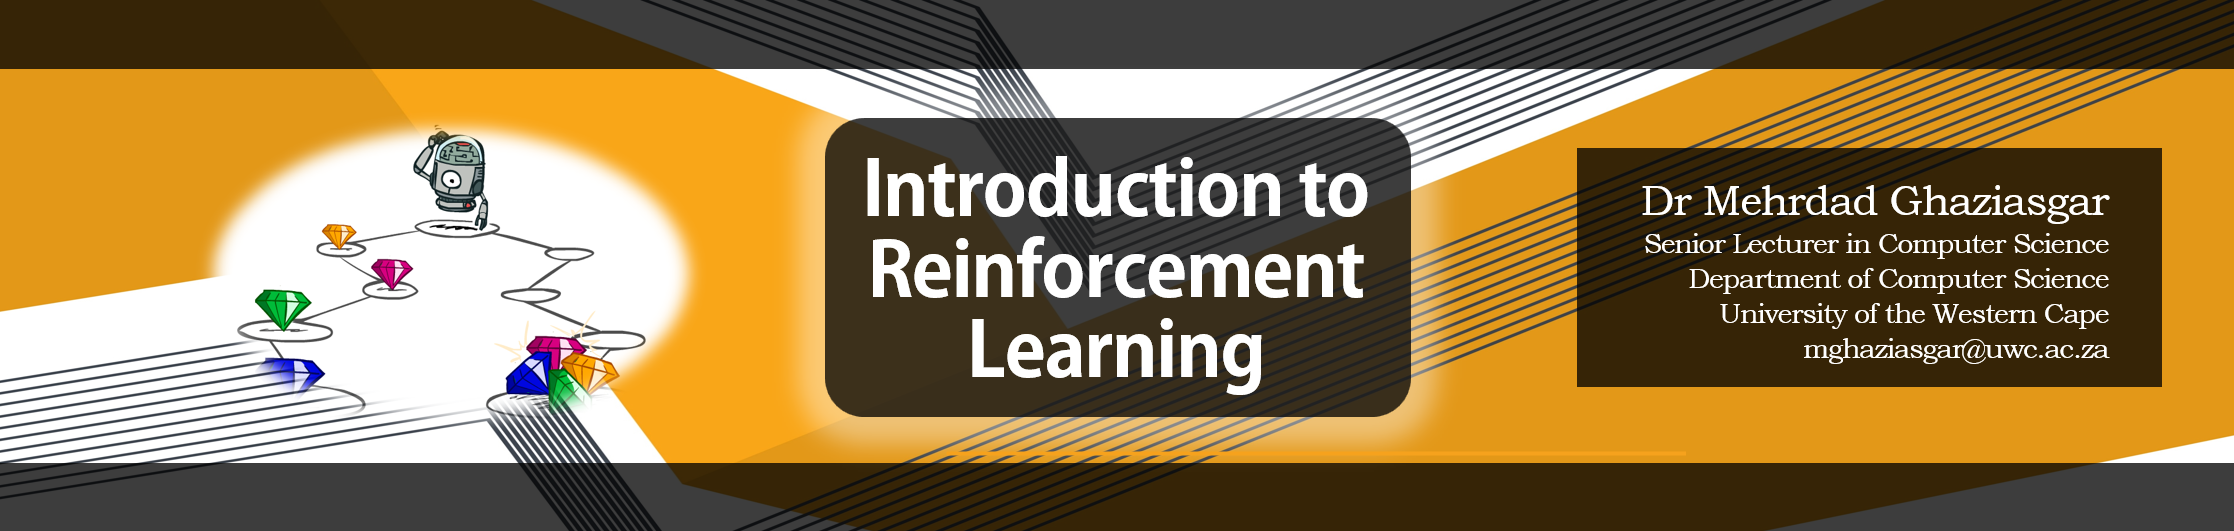

# Practical Exercise 2 - Reinforcement Learning with $Q$-Learning [40 marks]

In this exercise, you'll be putting into practice all of the knowledge obtained in the first part of the course to do with MDPs. I'll be giving you the basic structure of a generic MDP. The MDP can be customized to virtually any kind of problem by specifying its parameters i.e. states, transition and rewards functions.

Your job will ultimately be to familiarize yourself with the MDP structure to be able to implement an actual MDP for a given problem. More importantly, you'll have to implement value iteration, policy iteration and policy extraction. Bon apetit!

### Student Identifier

Please type in your student identifier below by setting the value of the student number variable. Don't change anything; just put in your student number

In [1]:
STUDENTNUMBER = "oumarou Moussa Bola" #
collaborator=   "Dishanan Jayeprokash"

Ok let's import a whole heap of libraries that we'll be using.

In [8]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output
import random
import numpy as np
from tqdm import tqdm
import pickle
import os
import utils2 as utils

And here, we'll be initializing the gym(nasium) `Taxi-v3` gym that we'll be using. I've specified the render_mode as `rgb_array` because this means that when we call the `env.render` method, it returns an image which we can then display for demo purposes (and NOT for training purposes). 

In [9]:
env = gym.make("Taxi-v3",render_mode='rgb_array')

The gym(nasium) library is a powerful rich library that allows for seamless simulation of a variety of environments with a very simple interface that can be accessed via Python. Each simulation has states and actions; it also provides a function that allows the agent to take an action; the gym then carries out the internal simulation using that action and provides feedback about the next state, the reward obtained and various other information. For information specific to the `Taxi-v3` such as the state space, the observation space, the rewards structure and other things, feel free to read through its webpage: <a href='https://gymnasium.farama.org/environments/toy_text/taxi/'>Gymnasium - Taxi-v3</a>

---
## 1. Creating the `QLearner` Class [15 marks]

So now we'll go right ahead and implement functionality we need for $Q$-learning to work. I've once again done the heavy-lifting and created the class below, along with a lot of functionality and framework. You will only need to implement key parts of the class to do with $Q$-learning, as clearly indicated by segments of code saying:

```#START CODING HERE#```

```#STOP CODING HERE#```

Don't edit anything above or below these two comments.

For the function `getComputeUpdatedQ` below, you will be implementing the right side of the following equation:

$$
Q(s,a) \leftarrow (1-\alpha) Q(s,a) + \alpha\Big[r+\gamma\max_{a'}Q(s',a')\Big]
$$


In [10]:
class QLearner:
    
    def __init__(self, env, load_from_file=None, alpha=0.1,gamma=0.9,epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.env = env
        
        #START CODING HERE ~ 1 line#
        
        #Set self.q_table to be a numpy array of zeroes with dimensionality (env.observation_space.n x env.action_space.n)
        
        self.q_table = np.zeros((env.observation_space.n,env.action_space.n)) #Set this correctly 
        
        #STOP CODING HERE#
        
        if load_from_file:
            q_table = self.getLoadQModelFromFile(load_from_file)
            
            if q_table is not None:
                self.q_table = q_table
    
    def getSelectAction(self, state):
        
        #START CODING HERE ~1 line#
        
        #   Pick an action randomly out of the list of available actions.
        #   Gym provides a function self.env.action_space.sample() that might help here
        
        action = self.env.action_space.sample()#This needs to be set correctly based on the above
        
        #STOP CODING HERE#
        return action

    def getComputeUpdatedQ(self, state, action, reward, next_state):

        #For convenience; I just didn't want to keep saying self.q_table, self.q_table, self.q_table...
        #So I set q_table to self.q_table, and then I just refer to q_table.
        q_table = self.q_table
        
        #START CODING HERE ~ 1-5 lines#
        #Use the Q-learning equation to get the updated value of Q(s,a) given
        
        q_init=(1-self.alpha)*q_table[state,action] + self.alpha*(reward+self.gamma*q_table[next_state, np.argmax(q_table[next_state])])
       
        #to you in the MarkDown cell above this one. You can either do it
        #in one line (not recommended), or you can split it up e.g.
        #get the current Q(s,a), get the max Q(s',a') for all a', and then
        #put them together...

        new_value =q_init #Set this correctly based on the above description
        
        #STOP CODING HERE#
        return new_value

    def getBestAction(self, state):
        
        #START CODING HERE ~ 1-2 lines#
        #Do a lookup in the self.q_table for the action
        #corresponding to the highest Q-value for state `state.
        #np.argmax can come in handy here. Actually, this will be
        #the same as some part of the `getSelectAction` function
        q_table=self.q_table
        action =np.argmax(q_table[state])# Set this correctly using above description
        #STOP CODING HERE#
        return action
   
    def doTrain(self, episodes, save_every=1000, save_file='qlearnmodel.pkl', do_render=False):

        print("Training started.")
        q_table = self.q_table        
        episode_total_reward = []
        episode_total_steps = []
        
        for episode in tqdm(range(1, episodes+1), desc="Training", unit=" episode"):
            state, info = self.env.reset()

            done = False
            
            episode_reward, episode_steps = 0., 0
            

            while not done:
                
                action = self.getSelectAction(state)

                next_state, reward, done, truncated, info = self.env.step(action) 
                
                if do_render:
                    clear_output(wait=True)
                    plt.imshow( self.env.render() )
                    plt.show()
                
                episode_reward += reward
                episode_steps+=1

                q_table[state, action] = self.getComputeUpdatedQ(state, action, reward, next_state)

                state = next_state
            
            episode_total_reward.append(episode_reward)
            episode_total_steps.append(episode_steps)

            if save_file and episode % save_every == 0:
                with open(save_file, 'wb') as file:
                    pickle.dump(q_table, file)

        print("Training finished.\n")
        if save_file:
            print("Saving...")
            with open(save_file, 'wb') as file:
                pickle.dump(q_table, file)
            print("Saved.")
        
        return np.array(episode_total_reward), np.array(episode_total_steps)
            
    def doDemo(self, episodes, do_render=True):
        
        if do_render:
            loop = range(1,episodes+1)
        else:
            loop = tqdm(range(1,episodes+1),desc="Simulating",unit=" episode", position=0, leave=True)
        
        
        for episode in loop:
            state, info = self.env.reset()
            
#             if do_render:
#                 self.env.render()
                
            done = False

            while not done:
                action = self.getBestAction(state)
                state, reward, done, truncated, info = self.env.step(action)

                if do_render:
                    clear_output(wait=True)
                    plt.imshow( self.env.render() )
                    plt.show()

        
                               
    def getLoadQModelFromFile(self, filename="qlearnmodel.pkl"):
        """
        Load an object from a file using pickle.

        Parameters:
        - filename: The name of the file containing the object.

        Returns:
        - The loaded object, or None if the file doesn't exist.
        """
        if not os.path.exists(filename):
            return None

        with open(filename, 'rb') as file:
            loaded_object = pickle.load(file)
        return loaded_object
                            


---

Let's see if all is well. Run the auto-marking cell below to see how it goes:

In [11]:
t1 = QLearner(env)
t2 = QLearner(env)
_ = utils.testCell(utils.params1(t1=t1,t2=t2))

______________________________

Test: Check Q-Table Dimensions
______________________________
Result: Passed! Mark: 1.5
______________________________

______________________________

Test: Check getSelectAction Function
______________________________
Result: Passed! Mark: 1.5
______________________________

______________________________

Test: Check getComputeUpdatedQ Function
______________________________
Result: Passed! Mark: 6
______________________________

______________________________

Test: Check getBestAction Function
______________________________
Result: Passed! Mark: 3
______________________________

Looks good from the few tests done! Marks: 12.0


---

Ok, let's go ahead and fire it up. Don't expect too much yet. This QLearner has a very basic exploration strategy: it just takes random actions every time step. Given enough time, good chance it will converge, but it will take time. Hopefully you have an intuition about the fact that this QLearner will have a high regret: imagine that every time it happens to be next to a wall, instead of (at least some of the time) leveraging what it knows about the negative reward associated with bumping walls, it just takes a random action; this means that it could well (and probably does) bump into the wall a good many times.

First, just for interest-sake, let's run training for one episode (which should run for a maximum of 200 transitions) and actually visualize it, just to see how the strategy pans out.

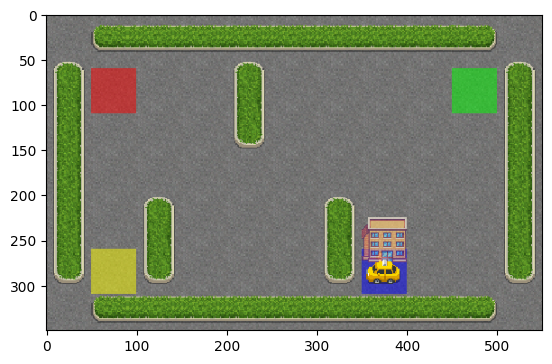

Training: 100%|█████████████████████████████| 1/1 [00:13<00:00, 13.26s/ episode]


Training finished.

Saving...
Saved.


In [6]:
qlearnrand = QLearner(env)
_,_ = qlearnrand.doTrain(1,do_render=True)

---

Ok and now let's run it without visualization to speed it up and do it over many more episodes. It does still take long though.

In [12]:
qlearnrand = QLearner(env)

episode_total_rewards_rand, episode_total_steps_rand = qlearnrand.doTrain(500)


Training started.


Training: 100%|█████████████████████████| 500/500 [00:08<00:00, 56.54 episode/s]

Training finished.

Saving...
Saved.


Ok, so the `doTrain` method returns some information from the training process (i.e. exploration and Q-learning updates combined) that we can use to determine how far along this strategy is in the convergence process. There are many ways to do this; in this implementation, the `doTrain` function returns the total number of steps taken in each episode (max of 200) and the total rewards it obtained in each episode.

Unfortunately, the agent is choosing actions purely at random, and so although it will be learning from its experiences, the actions it takes are still random, meaning that the overall rewards over every episode should in general be quite low and inconsistent. (When we use $\epsilon$-greedy Q-learning, this problem will be addressed). Anyway, we'll still just use the total number of steps taken in each episode (max of 200) and the total rewards it obtained in each episode and use them in some kind of a plot.

One thing we could do is to just plot the rewards obtained in each episode versus the episode number; this should work, but the plot will be very noisy and won't show much of trend. Let's try this below. I've written a function that uses the `matplotlib` library to plot a graph. In this case, we'll do a scatter plot because the points are super noisy, so if we try to join them, we'll get a meaningless "modern art"-type creation. Let's do it below **[1 mark]**

<class 'numpy.ndarray'>


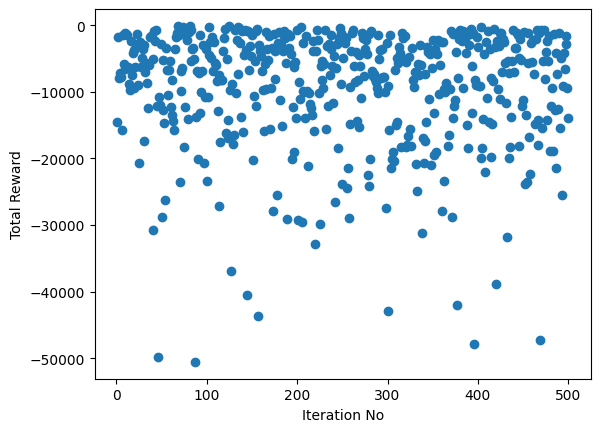

In [13]:

def plotData(y,x=None,xaxislabel="Iteration No",yaxislabel="Total Reward",scatter=False, window_width=None, label=None, legend=None):
    if not x:
        if not window_width:
            x = list(range(1,len(y)+1))
        else:
            x = list(range(window_width,window_width + len(y)))
    
    if scatter:
        plt.scatter(x,y,label=label)
    else:
        plt.plot(x, y,label=label)
    plt.xlabel(xaxislabel)
    plt.ylabel(yaxislabel)
    
    if legend:
        plt.legend()
    
    return

#START CODING HERE ~ 1 line of code#
#Call the plotData function to plot episode_total_rewards; make sure to set the plotData function's `scatter` parameter to True
print(type(episode_total_rewards_rand))
plotData(episode_total_rewards_rand,scatter=True)
#END CODING HERE


As expected the plot is very noisy. A better thing to do might be to take an average of the rewards across a number of episodes, using a sliding window. To be specific, we won't plot the rewards at each episode; rather, we'll plot the average reward for the past $N$ episodes at each iteration. This will provide more of a trend. Let's try that below. I've written a function that takes in a rewardslist that just contains rewards over a number of episodes; it then computes a sliding window as described before. In this case, we'll plot a line graph to see if there's any kind of trend. **[2 marks]**

<class 'numpy.ndarray'>


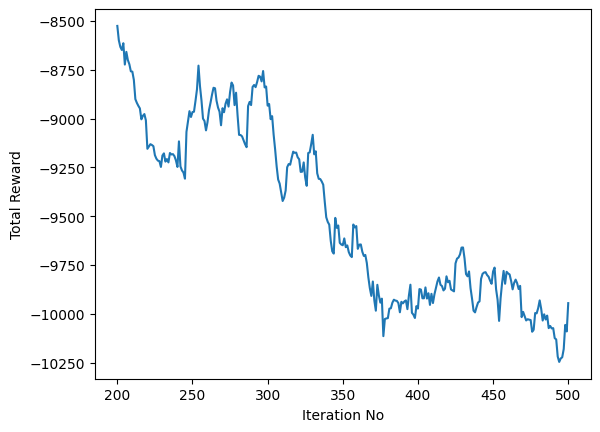

In [14]:
def getSlidingWindowSum(rewardslist, window_width = 500):
    thelist = np.array(rewardslist)

    cumulative_sum = np.cumsum(thelist)

    # Compute the sum of each moving window
    sum_of_windows = cumulative_sum[window_width-1:] - cumulative_sum[:-window_width+1] + np.array(thelist[:-window_width+1])
    
    return sum_of_windows/window_width

#The window width
ww =200

#START CODING HERE ~ 2-3 lines of code#
#1. Call the getSlidingWindowSum function; pass in episode_total_rewards_rand; it will return a numpy array of the
#   average rewards in each sliding window 
average_rewards=getSlidingWindowSum(episode_total_rewards_rand,ww)
#2. Call the plotData function to plot the average rewards obtained from the previous function;
#   in this case DON'T set the plotData function's `scatter` parameter to True. Just leave it blank so it plots a line.
#   ALSO, set the plotData function's window_width parameter to `ww`; this will make the plotData function adjust the 
#   horizontal axis to account for the fact that the first data point is actually at episode ww
print(type(average_rewards))
plotData(average_rewards,window_width=ww)
#END CODING HERE



The plot is much less noisy because we're capturing the average reward over a number of episodes. Nevertheless, hopefully you can see that there's still no trend to speak of, and looks very much like the loadshedding stages on any given week. It's quite... random... because we took purely random actions. Well that's what we expected (hopefully 'we' doesn't only mean 'me'?) 

Later on, we'll see that plotting this for a strategy that is not purely random will produce a very meaningful graph that can help us determine whether the strategy has converged.

---

Anyway, so even though the plot is not meaningful, the agent **has** been learning from its random experiences. It's quite difficult to tell how good the training has been, and whether it has traversed all (or even many) of the available (state,action) pairs in order to find out what's good and what's not. Only one way to tell; let's run it below.

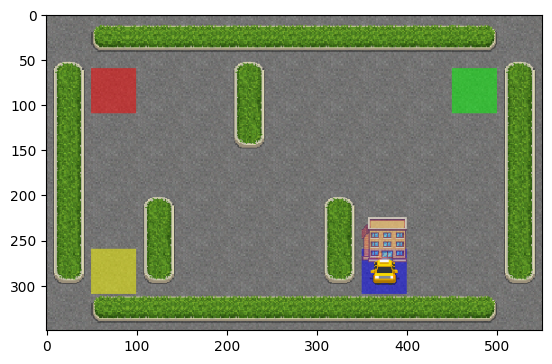

In [16]:
qlearnrand.doDemo(5)

AMAZING! Even though we acted totally randomly, $Q$-learning is robust enough to learn from those experiences and converge to the optimal policy.

---

## 2. Implementing $\epsilon$-Greedy Exploration [8 marks]

So all we really need to change from the `QLearner` class we previously implemented is the exploration strategy. Nothing else changes. And luckily, the selection of the action in each iteration of the simluation was done by calling the `getSelectAction` function which, currently, just picks and returns a random action out of the available actions.

Below, I'm going to create a new class called `QLearnerEpsilonGreedy` that inherits from the `QLearner` class - this means that it is essentially an exact copy of the `QLearner` class. However, if we choose to define any functions in this new (child) class, then those functions will override the same functions in the parent `QLearner` class. In this case, we only need to change (i.e. re-define) the `getSelectAction` method and put in code to allow the agent to choose actions using the $\epsilon$-greedy exploration strategy. This will override the `getSelectAction` in the parent class (`QLearner`) without changing any of the other functions or functionality.

In [18]:
class QLearnerEpsilonGreedy(QLearner):
    
    def getSelectAction(self, state):
        
        #START CODING HERE ~ +-5 lines#
        
        #Implement the epsilon-greedy strategy as follows:
        
        #1. Generate a random number from a uniform distribution in the range (0,1); use 
        #   random.uniform or np.random.uniform
        n=np.random.uniform(0,1)
        #2. Check if the random number is less than self.epsilon.
        #   If it is, pick the action randomly out of the list of available actions (as we had it before)
        if n <= self.epsilon :
            action= self.env.action_space.sample()
            #print(selec_action)
        else :
            #q_table=self.q_table
            action = self.getBestAction(state)
            #print(selec_action)
        #   If not, pick the action from self.q_table; pick the action corresponding to
        #   `state` with the highest value. You've already implemented the self.doBestAction(state) function which
        #   you can now use
        #action =selec_action #This needs to be set correctly based on the above
        #STOP CODING HERE#
        return action

---

Let's see if all is well. Run the auto-marking cell below to see how it goes:

In [19]:
t1 = QLearnerEpsilonGreedy(env,epsilon=0.5)
_ = utils.testCell(utils.params2(t1=t1))

______________________________

Test: Check Updated (epsilon-greedy) getSelectAction Function
______________________________
Result: Passed! Mark: 8
______________________________

Looks good from the few tests done! Marks: 8


Ok, let's go ahead and fire it up. Feel free to expect a LOT here. This QLearner has a very good exploration strategy: a small portion of the time, it tries out random actions; the rest of the time it picks the best action in the state its currently in. This makes exploration a lot more consistent and focused. It will mean that, for example, it won't repeatedly and meaninglessly keep bumping into a wall over and over again; well maybe some small portion of the time; but the rest of the time it will avoid these kinds of negative actions.

---

First, just for interest-sake, let's run training for one episode (which should run for a maximum of 200 transitions) and actually visualize it, just to see how the strategy pans out.

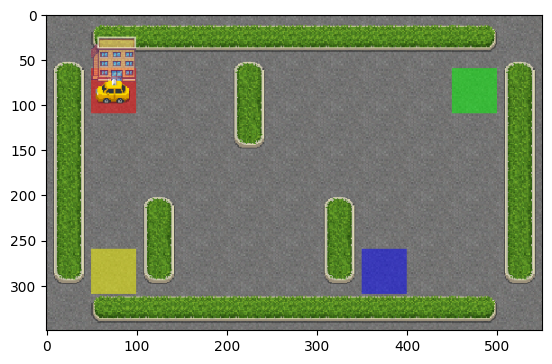

Training: 100%|█████████████████████████████| 1/1 [00:58<00:00, 58.57s/ episode]

Training finished.

Saving...
Saved.


In [20]:
qlearnepsilon = QLearnerEpsilonGreedy(env,epsilon=0.1)
_,_ = qlearnepsilon.doTrain(1,do_render=True)

---
Ok now let's actually train it without the visualization (which slows it down significantly). In general, this exploration strategy should converge much faster the random strategy did, and should also have a much lower regret than the previous (random) strategy. Overall, training will also be significantly faster; and will get faster and faster as training progresses. Can you figure out why? Think of the effect of having a really good set of $Q$-values around episode 1500 will mean compared to a horrible set of $Q$-values around episode 10.

In [21]:
qlearnepsilon = QLearnerEpsilonGreedy(env,epsilon=0.1)

episode_total_rewards_eps, episode_total_steps_eps = qlearnepsilon.doTrain(4000)


Training started.


Training: 100%|█████████████████████| 4000/4000 [00:01<00:00, 3428.19 episode/s]

Training finished.

Saving...
Saved.


Ok, so, as before, the `doTrain` method returns the total rewards for each episode and the number of iterations in each episode from the training process. Below, we'll again plot the rewards per episode (without the sliding window). Go ahead and do it. One line of code. 

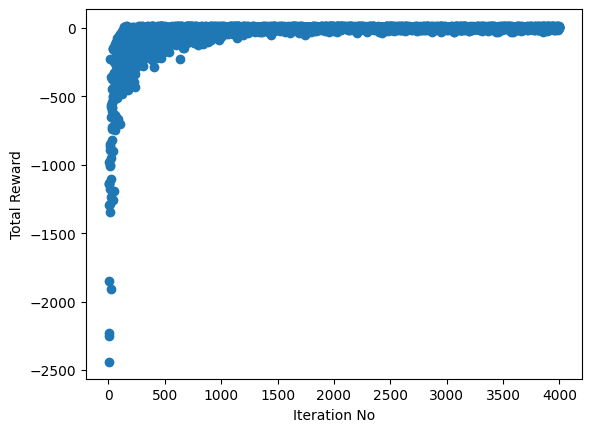

In [28]:
#START CODING HERE#
#Call plotData with episode_total_rewards_eps
plotData(episode_total_rewards_eps,scatter=True)
#STOP CODING HERE#

Well this plot is noisy but not trendless. Hopefully you can clearly see that it started out with really low rewards (less than -3000) and then rapidly learnt what's not good, raising the rewards in about 200 episodes, and essentially converged at around... well its hard to say where it converged because the graph is super noisy. So now, let's use the sliding window technique to smooth out the graph and make it more readable. 

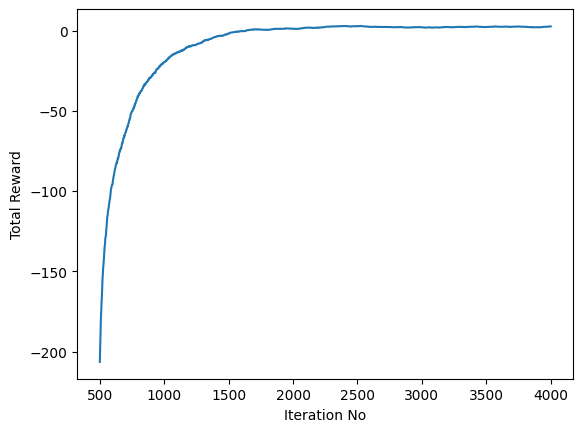

In [30]:
#The window width
ww = 500

#START CODING HERE ~ 2 lines of code#
#1. Call the getSlidingWindowSum function; pass in episode_total_rewards_eps; it will return a numpy array of the
#   average rewards in each sliding window 
avg_rewards=getSlidingWindowSum(episode_total_rewards_eps,ww)
#2. Call the plotData function to plot the average rewards obtained from the previous function;
#   in this case DON'T set the plotData function's `scatter` parameter to True. Just leave it blank so it plots a line.
#   ALSO, set the plotData function's window_width parameter to `ww`; this will make the plotData function adjust the 
#   horizontal axis to account for the fact that the first data point is actually at episode ww
plotData(avg_rewards,window_width=ww)
#END CODING HERE


AH that's better! Now we can quite clearly see that it converges at somewhere around just over 1500 episodes.

---

Anyway, so now we're almost sure that our $Q$-learning model has converged and the agent has learnt all that it can learn; let's run it below.

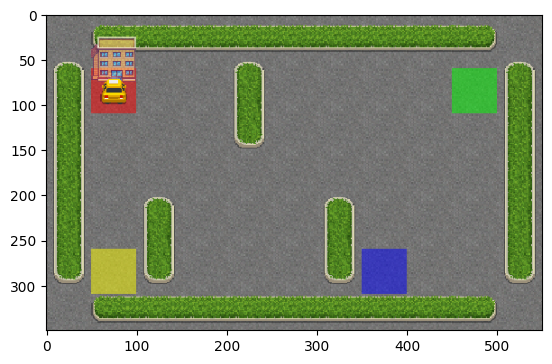

In [33]:
qlearnepsilon.doDemo(5)

AMAZING! $Q$-learning has learnt the optimal policy, and this time the training procedure lasted a fraction of the previous time, and probably also converged a lot sooner (although we can't easily tell this for the random strategy).

---

## 3. Implementing $Q$-Learning With an Exploration Function [17 Marks]

And now again, we can take what we had (`QLearner` class) and just change what's necessary. 

There are many ways to design exploration functions. In this implementation, we'll primarily focus on using some adaptation of the method spoken about in class. We discussed the use of a function $N = u + k / n$ to provide a boost to $Q$ values of state-action pairs that are less explored. Here's what we'll do: we'll modify our action selection function (`getSelectAction`) such that the selection of the action is based on the following function: 

$$
a = \text{arg}\max_a \Bigg[Q(s,a)+\frac{k}{N(s,a)+1}\Bigg]
$$

where $k$ is a constant which we will assume can be 5.0 in our implementation, and $N$ is a table/matrix keeping track of the number of visits to each state-action pair, and so $N(s,a)$ refers to the number of visits to the pair $(s,a)$.

To implement this, we will need to do the folowing:

1. The class constructor of `QLearner` needs to be re-defined in order to:

    i. Define a matrix `num_state_action_visits` representing $N(s,a)$ which will have the exact same structure as the `q_table` and will just be used to keep track of the number of times a specific (state,action) pair is tried out by the agent. 
    
    ii. Define and specify the parameter `k`.
    <br>
2. We'll need to re-define the `getSelectAction` function to:

    i. Select an action based on the function described above.
    
    ii. Increment the value of num_state_action_visits[state,action] by 1.
<br>
    
This looks like a lot of change, but it's actually small things. I've put in the skeletons below; you only need to put in the small changes.

In [64]:
class QLearnerExplorationFunction(QLearner):
    
    def __init__(self, env, load_from_file=None, alpha=0.1,gamma=0.9,epsilon=0.1, k=5.0):
        super().__init__(env,load_from_file,alpha,gamma,epsilon)
        
        #START CODING HERE#
        
        #Set self.num_state_action_visits to be a table of zeros of exactly the same structure as self.q_table.
        #There's at least two ways I can think of to do this.
        self.k = k
    
        self.num_state_action_visits = np.zeros((env.observation_space.n,env.action_space.n)) #Set this correctly # N(s,a)
        N_sa=self.num_state_action_visits
        #STOP CODING HERE#

    def getSelectAction(self, state):
        
        #START CODING HERE ~ 1-4 lines#
        
        #Implement the exploration strategy
        N_sa=self.num_state_action_visits
        #   First, notice that self.q_table[state] is actually a row of Q values in the q_table for all actions for that state
        #   Pick the action from self.q_table[state] that has the max(Q + self.k/n);
        q_table=self.q_table
        action =np.argmax(q_table[state]+ self.k/(N_sa[state]+1)  )  #This needs to be set correctly based on the above
        #STOP CODING HERE#
        #START CODING HERE ~ 1 line#
        N_sa[state,action]=N_sa[state,action]+1
        #Increment the value in self.num_state_action_visits corresponding to state and action by 1
        #STOP CODING HERE#
      
        
        return action        


---

Let's see if all is well. Run the auto-marking cell below to see how it goes:

In [84]:
t1 = QLearnerExplorationFunction(env,k=10)
_ = utils.testCell(utils.params3(t1=t1))

______________________________

Test: Check num_state_action_visits Dimensions
______________________________
Result: Passed! Mark: 1
______________________________

______________________________

Test: Check Updated getSelectAction Function
______________________________
Result: Passed! Mark: 13
______________________________

Looks good from the few tests done! Marks: 14


Ok, let's go ahead and fire it up. Feel free to expect a LOT more here. This QLearner has a very good exploration strategy. Here, the search is completely guided with no randomness. This should do better than the previous strategy.

First, let's visualize this exploration strategy for interest-sake (or you can skip it if you like). Note that initially, it might look like its stuck; it most likely isn't. It's just doing things it hasn't done before over and over again until $N(s,a)$ becomes large (i.e. its done them a lot) and so the exploration bonus $(k / N(s,a))$ "runs out" and it then moves on.

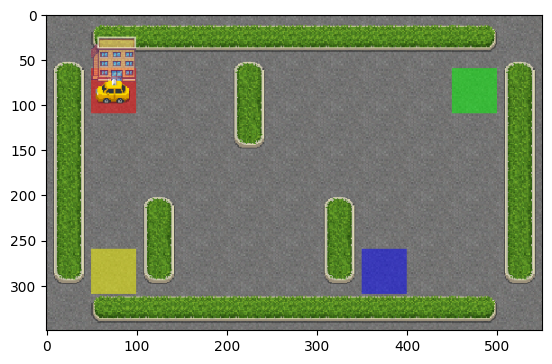

Training: 100%|█████████████████████████████| 1/1 [01:16<00:00, 76.72s/ episode]

Training finished.

Saving...
Saved.


In [95]:
qlearnexp = QLearnerExplorationFunction(env,epsilon=0.1,k=5.0,gamma=0.9)

_,_ = qlearnexp.doTrain(1, do_render=True)


---

Ok let's now train it without the visualization.

In [96]:
qlearnexp = QLearnerExplorationFunction(env,epsilon=0.1,k=5.0,gamma=0.9)

episode_total_rewards_exp, episode_total_steps_exp = qlearnexp.doTrain(4000)


Training started.


Training: 100%|█████████████████████| 4000/4000 [00:01<00:00, 3304.46 episode/s]

Training finished.

Saving...
Saved.


Ok, so, as before, the `doTrain` method returns the total rewards for each episode and the number of iterations in each episode from the training process. Below, we'll again plot the rewards per episode (without the sliding window). Go ahead and do it. One line of code. 

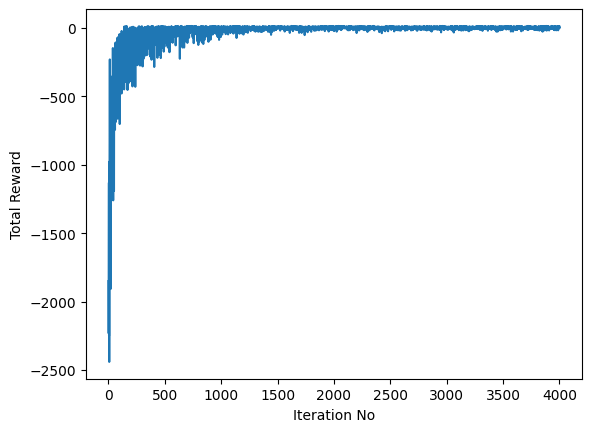

In [97]:
#START CODING HERE#

#Call plotData with episode_total_rewards_eps
plotData(episode_total_rewards_eps)
#STOP CODING HERE#

Well this plot is noisy but not trendless. Hopefully you can clearly see that it started out with really low rewards and then rapidly learnt what's good and what's not good, rapidly raising the rewards in about 200 episodes, and essentially converged at around... well its hard to say where it converged because the graph is super noisy. So now, let's use the sliding window technique to smooth out the graph and make it more readable. 

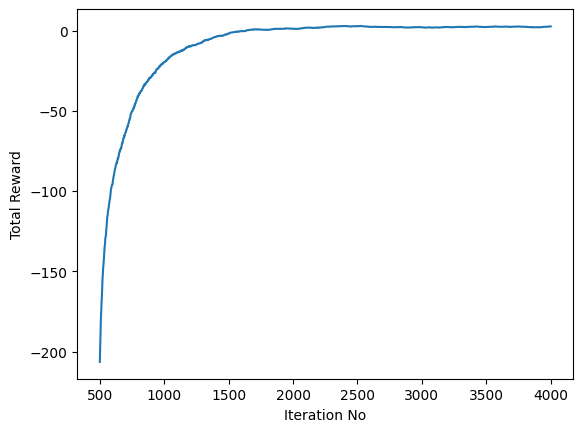

In [98]:
#The window width
ww = 500

#START CODING HERE ~ 2 lines of code#
#1. Call the getSlidingWindowSum function; pass in episode_total_rewards_eps; it will return a numpy array of the
#   average rewards in each sliding window 
Avg_Rewards=getSlidingWindowSum(episode_total_rewards_eps,ww)
#2. Call the plotData function to plot the average rewards obtained from the previous function;
#   in this case DON'T set the plotData function's `scatter` parameter to True. Just leave it blank so it plots a line.
#   ALSO, set the plotData function's window_width parameter to `ww`; this will make the plotData function adjust the 
#   horizontal axis to account for the fact that the first data point is actually at episode ww
plotData(Avg_Rewards,window_width=ww)
#END CODING HERE


AH that's better! Now we can quite clearly see that it converges at somewhere around just over 1500 episodes. This is comparable to the convergence rate of the $\epsilon$-greedy approach. However, if we plot the two plots on the same graph, we might see something interesting. Below, let's use the `plotData` function to plot both graphs together to compare them. Go ahead and do it. All you need to do is call the `plotData` function twice with the relevant data, and make sure to provide the `label` parameter and set the `legend` parameter to `True` so you can see what's what **[3 marks]**

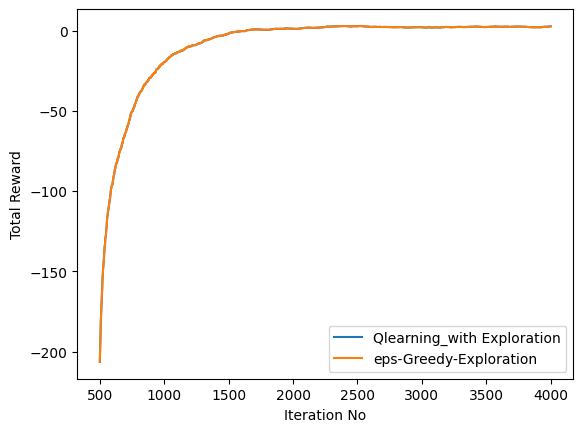

In [99]:
#START CODING HERE
plotData(Avg_Rewards,window_width=ww,label="Qlearning_with Exploration",legend=True)
plotData(avg_rewards,window_width=ww,label="eps-Greedy-Exploration",legend=True)
#END CODING HERE

Ah so while they seem to converge at the same number of episodes, the exploration function comes up with a superior strategy that has higher reward...

---

Anyway, so now we've seen that our superior $Q$-learning model has converged and the agent has learnt all that it can learn; let's run it below.

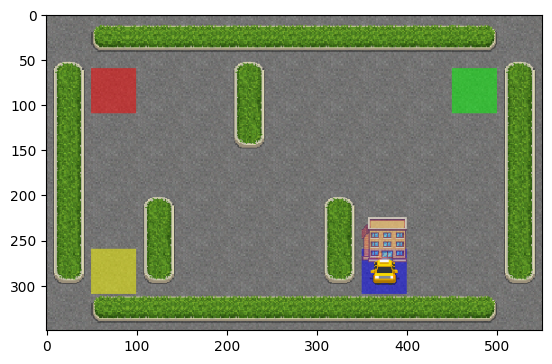

In [100]:
qlearnexp.doDemo(5)

---
---

## BONAAS: Readily applying out QLearning Algorithm to a Different Simulation [0 marks but plenty rewards]

So below, I've put in code that intializes a different AI gymnasium simulation and applies the `QLearnerExplorationFunction` to it. It should just work right out of the box.


In [101]:
env2 = gym.make("CliffWalking-v0",render_mode='rgb_array')
qlearncliff = QLearnerExplorationFunction(env2)  # You actually can just swap this in: QLearnerEpsilonGreedy(env2)

Here's a demo of the learning in action:

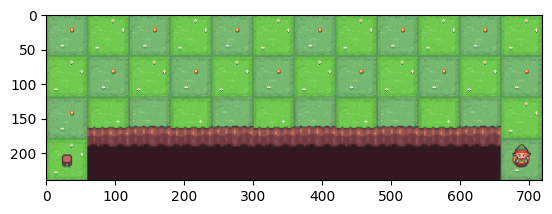

Training: 100%|█████████████████████████████| 1/1 [00:07<00:00,  7.07s/ episode]

Training finished.

Saving...
Saved.


In [102]:
_, _ = qlearncliff.doTrain(1, do_render=True)

Training time:

In [103]:
rew_cliff, _ = qlearncliff.doTrain(400)

Training started.


Training: 100%|███████████████████████| 400/400 [00:00<00:00, 3593.64 episode/s]

Training finished.

Saving...
Saved.


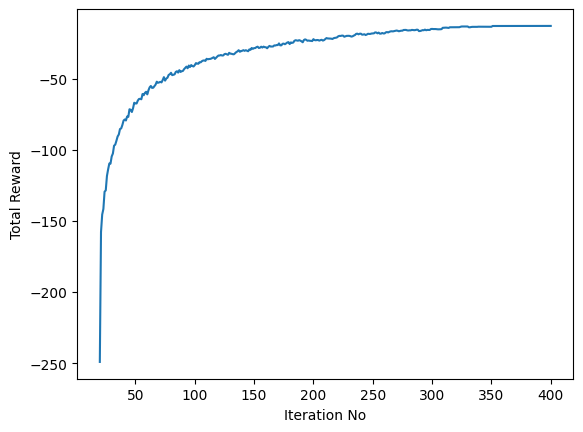

In [104]:
#Plotting to make sure it has converged
rew_cliff_slid = getSlidingWindowSum(rew_cliff, window_width = 20)
plotData(rew_cliff_slid, window_width = 20)

Fire it UP!

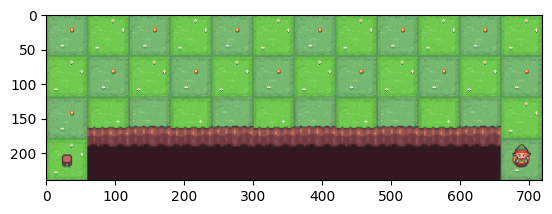

In [109]:
qlearncliff.doDemo(5)

In [108]:
#np.zeros((4,4))

---

## THE END - of the course [ :) or :'(?]